# ML Pipeline

## Data Preparation

In [4]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle
import json




### Extracting refined dataset from Google Storage Bucket

In [5]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [6]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/03_refined/df_windowed_full.parquet"
base_dataset =  pd.read_parquet(path)

df = base_dataset.copy()

In [7]:
df[['Papel','Tipo','Setor','Subsetor']]

,Papel,Tipo,Setor,Subsetor
24,ABCB4,PN,Intermediários Financeiros,Bancos
25,ABCB4,PN,Intermediários Financeiros,Bancos
26,ABCB4,PN,Intermediários Financeiros,Bancos
27,ABCB4,PN,Intermediários Financeiros,Bancos
28,ABCB4,PN,Intermediários Financeiros,Bancos
...,...,...,...,...
91432,ORVR3,ON,Água e Saneamento,Água e Saneamento
91457,POWE3,ON,Energia Elétrica,Energia Elétrica
91458,POWE3,ON,Energia Elétrica,Energia Elétrica
91483,WEST3,ON,Programas e Serviços,Programas e Serviços


In [8]:
df = df[df.columns.sort_values()]

In [9]:
df.head()

,Data_ult_cot,Empresa,Lucro_Liquido_12m_category,Papel,Setor,Subsetor,Tipo,besst_1,besst_2,c5y_max_max,c5y_max_ref_max,c5y_mean_last,c5y_mean_mean,c5y_mean_ref_mean,c5y_mean_ref_std,c5y_mean_std,c5y_min_min,c5y_min_ref_min,c5y_ref_spread,c5y_spread,c5y_spread_relevance,cotacao_max_max,cotacao_max_ref_max,cotacao_mean_last,cotacao_mean_mean,cotacao_mean_ref_mean,cotacao_mean_ref_std,cotacao_mean_std,cotacao_min_min,cotacao_min_ref_min,cotacao_ref_spread,cotacao_spread,cotacao_spread_relevance,divbpatr_max_max,divbpatr_max_ref_max,divbpatr_mean_last,divbpatr_mean_mean,divbpatr_mean_ref_mean,divbpatr_mean_ref_std,divbpatr_mean_std,divbpatr_min_min,divbpatr_min_ref_min,divbpatr_ref_spread,divbpatr_spread,divbpatr_spread_relevance,dolar_comercial_last,dolar_comercial_max,dolar_comercial_mean,dolar_comercial_min,dolar_comercial_spread,dolar_comercial_spread_relevance,dolar_comercial_std,dy_label,dy_max_max,dy_max_ref_max,dy_mean_last,dy_mean_mean,dy_mean_ref_mean,dy_mean_ref_std,dy_mean_std,dy_median_last,dy_median_max,dy_median_min,dy_median_ref_max,dy_median_ref_min,dy_median_ref_spread,dy_median_spread,dy_median_spread_relevance,dy_min_min,dy_min_ref_min,dy_ref_spread,dy_spread,dy_spread_relevance,euro_last,euro_max,euro_mean,euro_min,euro_spread,euro_spread_relevance,euro_std,evebit_max_max,evebit_max_ref_max,evebit_mean_last,evebit_mean_mean,evebit_mean_ref_mean,evebit_mean_ref_std,evebit_mean_std,evebit_min_min,evebit_min_ref_min,evebit_ref_spread,evebit_spread,evebit_spread_relevance,ibovespa_last,ibovespa_max,ibovespa_mean,ibovespa_min,ibovespa_spread,ibovespa_spread_relevance,ibovespa_std,igpm_last,igpm_max,igpm_mean,igpm_min,igpm_spread,igpm_spread_relevance,igpm_std,indice_da_industria_last,indice_da_industria_max,indice_da_industria_mean,indice_da_industria_min,indice_da_industria_spread,indice_da_industria_spread_relevance,indice_da_industria_std,ipca_last,ipca_max,ipca_mean,ipca_min,ipca_spread,ipca_spread_relevance,ipca_std,liq2m_max_max,liq2m_max_ref_max,liq2m_mean_last,liq2m_mean_mean,liq2m_mean_ref_mean,liq2m_mean_ref_std,liq2m_mean_std,liq2m_min_min,liq2m_min_ref_min,liq2m_ref_spread,liq2m_spread,liq2m_spread_relevance,liqc_max_max,liqc_max_ref_max,liqc_mean_last,liqc_mean_mean,liqc_mean_ref_mean,liqc_mean_ref_std,liqc_mean_std,liqc_min_min,liqc_min_ref_min,liqc_ref_spread,liqc_spread,liqc_spread_relevance,month_last,mrgebit_max_max,mrgebit_max_ref_max,mrgebit_mean_last,mrgebit_mean_mean,mrgebit_mean_ref_mean,mrgebit_mean_ref_std,mrgebit_mean_std,mrgebit_min_min,mrgebit_min_ref_min,mrgebit_ref_spread,mrgebit_spread,mrgebit_spread_relevance,mrgliq_max_max,mrgliq_max_ref_max,mrgliq_mean_last,mrgliq_mean_mean,mrgliq_mean_ref_mean,mrgliq_mean_ref_std,mrgliq_mean_std,mrgliq_min_min,mrgliq_min_ref_min,mrgliq_ref_spread,mrgliq_spread,mrgliq_spread_relevance,pa_max_max,pa_max_ref_max,pa_mean_last,pa_mean_mean,pa_mean_ref_mean,pa_mean_ref_std,pa_mean_std,pa_min_min,pa_min_ref_min,pa_ref_spread,pa_spread,pa_spread_relevance,pacl_max_max,pacl_max_ref_max,pacl_mean_last,pacl_mean_mean,pacl_mean_ref_mean,pacl_mean_ref_std,pacl_mean_std,pacl_min_min,pacl_min_ref_min,pacl_ref_spread,pacl_spread,pacl_spread_relevance,patrliq_max_max,patrliq_max_ref_max,patrliq_mean_last,patrliq_mean_mean,patrliq_mean_ref_mean,patrliq_mean_ref_std,patrliq_mean_std,patrliq_min_min,patrliq_min_ref_min,patrliq_ref_spread,patrliq_spread,patrliq_spread_relevance,pcg_max_max,pcg_max_ref_max,pcg_mean_last,pcg_mean_mean,pcg_mean_ref_mean,pcg_mean_ref_std,pcg_mean_std,pcg_min_min,pcg_min_ref_min,pcg_ref_spread,pcg_spread,pcg_spread_relevance,pebit_max_max,pebit_max_ref_max,pebit_mean_last,pebit_mean_mean,pebit_mean_ref_mean,pebit_mean_ref_std,pebit_mean_std,pebit_min_min,pebit_min_ref_min,pebit_ref_spread,pebit_spread,pebit_spread_relevance,pib_dolarizado_last,pib_dolarizado_max,pib_dolarizado_mean,pib_dolarizado_min,pib_dolarizado_spread,pib_dolarizado_spread_relevance,pib_dolarizado_std,pl_max_max,pl_max_ref_max,pl_mean_last,pl_mean_mean,pl_mean_ref_mean

In [10]:
df[df.columns[df.dtypes=='float64']].max().sort_values(ascending=False)[:50].index

Index(['dy_spread_relevance', 'liq2m_ref_spread', 'liq2m_mean_ref_std',
       'liq2m_mean_ref_mean', 'liq2m_spread_relevance', 'liq2m_max_ref_max',
       'patrliq_spread_relevance', 'patrliq_ref_spread', 'patrliq_max_ref_max',
       'patrliq_mean_ref_std', 'psr_mean_ref_std', 'patrliq_mean_ref_mean',
       'psr_ref_spread', 'patrliq_max_max', 'patrliq_mean_mean',
       'patrliq_mean_last', 'patrliq_min_min', 'patrliq_spread',
       'patrliq_mean_std', 'liq2m_spread', 'pl_ref_spread', 'pl_max_ref_max',
       'liq2m_max_max', 'liq2m_mean_last', 'liq2m_mean_mean', 'liq2m_min_min',
       'liq2m_mean_std', 'pl_mean_ref_mean', 'pl_mean_ref_std',
       'psr_spread_relevance', 'pebit_spread_relevance', 'evebit_ref_spread',
       'evebit_max_ref_max', 'evebit_spread', 'pl_spread', 'pebit_spread',
       'evebit_max_max', 'pl_max_max', 'pebit_max_max', 'evebit_mean_last',
       'pl_mean_last', 'pebit_mean_last', 'pebit_ref_spread',
       'pebit_max_ref_max', 'pl_spread_relevance', 'e

In [11]:
columns_to_log  = df[df.columns[df.dtypes=='float64']].max().sort_values(ascending=False)[:50].index
# columns_to_drop = ['year']

In [12]:
# transforming the categorical values into numerical values
def transform_dummy(data, features):
    for feature in features:
        data[[(str(feature) + '_' + str(col)) for col in pd.get_dummies(data[feature]).columns]] = pd.get_dummies(data[feature])
        data.drop(feature,axis=1,inplace=True)
    return data

In [13]:
def logging_vars(data, cols):
    data_out = data.copy()
    for col in cols:
        data_out[col + '_log'] = np.log(data_out[col]+1)
    return data_out

In [14]:
def column_name_cleaner(col):
    return col.encode('utf-8', 'replace').decode('utf-8')


In [15]:
# df.columns = [column_name_cleaner(col) for col in df.columns]

df = logging_vars(df, columns_to_log)
df = df.drop(columns_to_log,axis=1)


c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value enc

In [16]:
# df.head()
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df = df.dropna()

In [17]:
df = transform_dummy(df,['Setor','Subsetor','Tipo','besst_1','besst_2'])

In [18]:
cor = df.corr()['dy_label']

<AxesSubplot:>

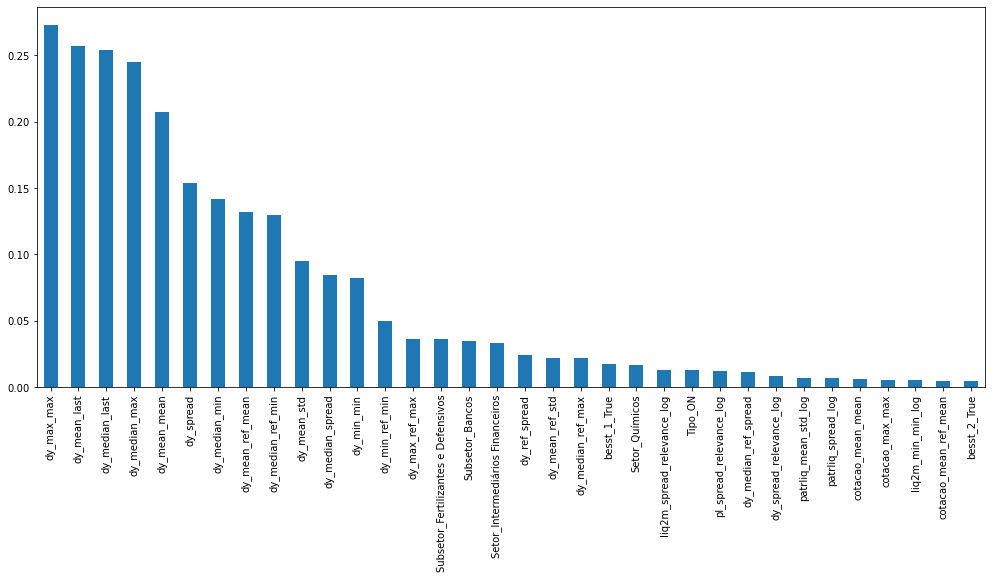

In [19]:
plt.figure(figsize=(17,7))
cor.sort_values(ascending=False)[1:35].plot(kind='bar')

<AxesSubplot:>

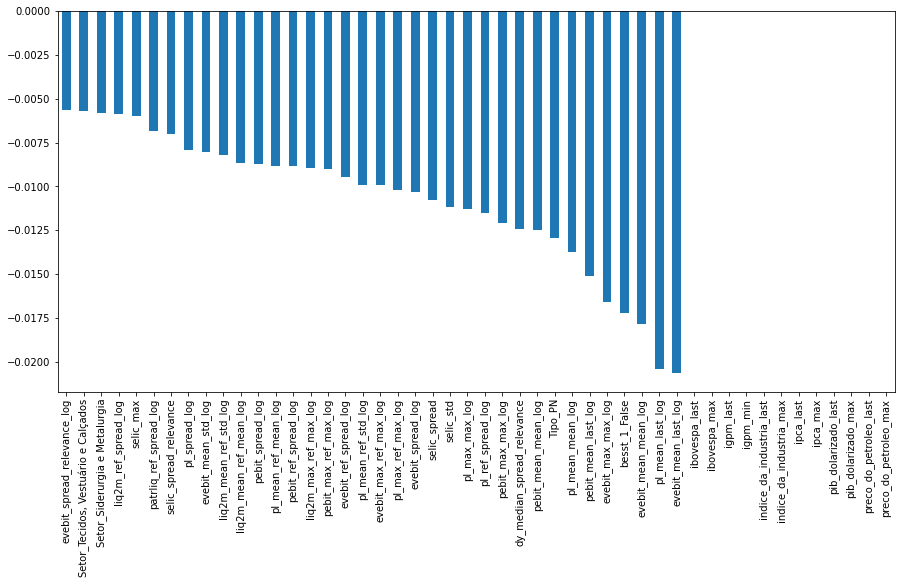

In [20]:
plt.figure(figsize=(15,7))
cor.sort_values(ascending=False)[380:].plot(kind='bar')

In [21]:
cor = df.corr()['dy_label']
# training_features = cor[((cor>0.02)&(cor<0.6))|((cor<-0.02)&(cor>-0.6))]

In [22]:
cor.sort_values(ascending=False)[1:35]

dy_max_max                             0.272963
dy_mean_last                           0.257239
dy_median_last                         0.253708
dy_median_max                          0.245030
dy_mean_mean                           0.206820
dy_spread                              0.153600
dy_median_min                          0.141313
dy_mean_ref_mean                       0.131805
dy_median_ref_min                      0.129618
dy_mean_std                            0.094749
dy_median_spread                       0.084290
dy_min_min                             0.082140
dy_min_ref_min                         0.049696
dy_max_ref_max                         0.036246
Subsetor_Fertilizantes e Defensivos    0.035991
Subsetor_Bancos                        0.034551
Setor_Intermediários Financeiros       0.032997
dy_ref_spread                          0.024030
dy_mean_ref_std                        0.022140
dy_median_ref_max                      0.021899
besst_1_True                           0

#### Adjust data types

In [23]:
df.columns

Index(['Data_ult_cot', 'Empresa', 'Lucro_Liquido_12m_category', 'Papel',
       'c5y_max_max', 'c5y_max_ref_max', 'c5y_mean_last', 'c5y_mean_mean',
       'c5y_mean_ref_mean', 'c5y_mean_ref_std',
       ...
       'Subsetor_Utensílios Domésticos', 'Subsetor_Vestuário',
       'Subsetor_Viagens e Turismo', 'Subsetor_Água e Saneamento', 'Tipo_ON',
       'Tipo_PN', 'besst_1_False', 'besst_1_True', 'besst_2_False',
       'besst_2_True'],
      dtype='object', length=431)

#### Encoding for object variables

In [24]:
# features_to_drop = ['Data_ult_cot','papel','date','Data_ult_cot_year','year']
# df.drop(features_to_drop, axis=1, inplace=True)

In [25]:
# df_objects = df.select_dtypes('object').copy()
# df_objects = df_objects.drop(['Empresa','Papel'], axis=1)
# object_cols = df_objects.columns
# print(object_cols)

In [26]:
# df_objects['Tipo'].astype('category').cat.codes

In [27]:
# for col in object_cols:
#     df[col] = df_objects[col].astype('category').cat.codes

# df.dtypes

#### Spliting data into training a test data

In [28]:
cor = df.corr()['dy_label']
minimum = 0.012
maximum = 0.6
training_features = cor[((cor>minimum)&(cor<maximum))|((cor>-maximum)&(cor<-minimum))]

In [29]:
df.head()

,Data_ult_cot,Empresa,Lucro_Liquido_12m_category,Papel,c5y_max_max,c5y_max_ref_max,c5y_mean_last,c5y_mean_mean,c5y_mean_ref_mean,c5y_mean_ref_std,c5y_mean_std,c5y_min_min,c5y_min_ref_min,c5y_ref_spread,c5y_spread,c5y_spread_relevance,cotacao_max_max,cotacao_max_ref_max,cotacao_mean_last,cotacao_mean_mean,cotacao_mean_ref_mean,cotacao_mean_ref_std,cotacao_mean_std,cotacao_min_min,cotacao_min_ref_min,cotacao_ref_spread,cotacao_spread,cotacao_spread_relevance,divbpatr_max_max,divbpatr_max_ref_max,divbpatr_mean_last,divbpatr_mean_mean,divbpatr_mean_ref_mean,divbpatr_mean_ref_std,divbpatr_mean_std,divbpatr_min_min,divbpatr_min_ref_min,divbpatr_ref_spread,divbpatr_spread,divbpatr_spread_relevance,dolar_comercial_last,dolar_comercial_max,dolar_comercial_mean,dolar_comercial_min,dolar_comercial_spread,dolar_comercial_spread_relevance,dolar_comercial_std,dy_label,dy_max_max,dy_max_ref_max,dy_mean_last,dy_mean_mean,dy_mean_ref_mean,dy_mean_ref_std,dy_mean_std,dy_median_last,dy_median_max,dy_median_min,dy_median_ref_max,dy_median_ref_min,dy_median_ref_spread,dy_median_spread,dy_median_spread_relevance,dy_min_min,dy_min_ref_min,dy_ref_spread,dy_spread,euro_last,euro_max,euro_mean,euro_min,euro_spread,euro_spread_relevance,euro_std,evebit_mean_ref_mean,evebit_mean_ref_std,evebit_min_min,evebit_min_ref_min,ibovespa_last,ibovespa_max,ibovespa_mean,ibovespa_min,ibovespa_spread,ibovespa_spread_relevance,ibovespa_std,igpm_last,igpm_max,igpm_mean,igpm_min,igpm_spread,igpm_spread_relevance,igpm_std,indice_da_industria_last,indice_da_industria_max,indice_da_industria_mean,indice_da_industria_min,indice_da_industria_spread,indice_da_industria_spread_relevance,indice_da_industria_std,ipca_last,ipca_max,ipca_mean,ipca_min,ipca_spread,ipca_spread_relevance,ipca_std,liq2m_min_ref_min,liqc_max_max,liqc_max_ref_max,liqc_mean_last,liqc_mean_mean,liqc_mean_ref_mean,liqc_mean_ref_std,liqc_mean_std,liqc_min_min,liqc_min_ref_min,liqc_ref_spread,liqc_spread,liqc_spread_relevance,month_last,mrgebit_max_max,mrgebit_max_ref_max,mrgebit_mean_last,mrgebit_mean_mean,mrgebit_mean_ref_mean,mrgebit_mean_ref_std,mrgebit_mean_std,mrgebit_min_min,mrgebit_min_ref_min,mrgebit_ref_spread,mrgebit_spread,mrgebit_spread_relevance,mrgliq_max_max,mrgliq_max_ref_max,mrgliq_mean_last,mrgliq_mean_mean,mrgliq_mean_ref_mean,mrgliq_mean_ref_std,mrgliq_mean_std,mrgliq_min_min,mrgliq_min_ref_min,mrgliq_ref_spread,mrgliq_spread,mrgliq_spread_relevance,pa_max_max,pa_max_ref_max,pa_mean_last,pa_mean_mean,pa_mean_ref_mean,pa_mean_ref_std,pa_mean_std,pa_min_min,pa_min_ref_min,pa_ref_spread,pa_spread,pa_spread_relevance,pacl_max_max,pacl_max_ref_max,pacl_mean_last,pacl_mean_mean,pacl_mean_ref_mean,pacl_mean_ref_std,pacl_mean_std,pacl_min_min,pacl_min_ref_min,pacl_ref_spread,pacl_spread,pacl_spread_relevance,patrliq_min_ref_min,pcg_max_max,pcg_max_ref_max,pcg_mean_last,pcg_mean_mean,pcg_mean_ref_mean,pcg_mean_ref_std,pcg_mean_std,pcg_min_min,pcg_min_ref_min,pcg_ref_spread,pcg_spread,pcg_spread_relevance,pebit_mean_ref_mean,pebit_mean_ref_std,pebit_mean_std,pebit_min_min,pebit_min_ref_min,pib_dolarizado_last,pib_dolarizado_max,pib_dolarizado_mean,pib_dolarizado_min,pib_dolarizado_spread,pib_dolarizado_spread_relevance,pib_dolarizado_std,pl_mean_std,pl_min_min,pl_min_ref_min,preco_do_petroleo_last,preco_do_petroleo_max,preco_do_petroleo_mean,preco_do_petroleo_min,...,roe_min_min,roe_min_ref_min,roe_ref_spread,roe_spread,roe_spread_relevance,roic_max_max,roic_max_ref_max,roic_mean_last,roic_mean_mean,roic_mean_ref_mean,roic_mean_ref_std,roic_mean_std,roic_min_min,roic_min_ref_min,roic_ref_spread,roic_spread,roic_spread_relevance,selic_last,selic_max,selic_mean,selic_min,selic_spread,selic_spread_relevance,selic_std,year_last,dy_spread_relevance_log,liq2m_ref_spread_log,liq2m_mean_ref_std_log,liq2m_mean_ref_mean_log,liq2m_spread_relevance_log,liq2m_max_ref_max_log,patrliq_spread_relevance_log,patrliq_ref_spread_log,patrliq_max_ref_max_log,patrliq_mean_ref_std_log,psr_mean_ref_std_log,patrliq_mean_r

In [30]:
df.isna().sum().sort_values(ascending=False)

liq2m_min_min_log       21592
pl_mean_last_log        16969
pl_mean_mean_log        16889
evebit_mean_last_log    16600
evebit_mean_mean_log    16463
                        ...  
mrgliq_min_ref_min          0
mrgliq_min_min              0
mrgliq_mean_std             0
mrgliq_mean_ref_std         0
besst_2_True                0
Length: 431, dtype: int64

In [31]:
sns.displot

<function seaborn.distributions.displot(data=None, *, x=None, y=None, hue=None, row=None, col=None, weights=None, kind='hist', rug=False, rug_kws=None, log_scale=None, legend=True, palette=None, hue_order=None, hue_norm=None, color=None, col_wrap=None, row_order=None, col_order=None, height=5, aspect=1, facet_kws=None, **kwargs)>

In [32]:
df['dy_spread_relevance_log'][df['dy_spread_relevance_log'] > 10] = 10

C:\Users\Pontello\AppData\Local\Temp\ipykernel_14292\4015203285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dy_spread_relevance_log'][df['dy_spread_relevance_log'] > 10] = 10


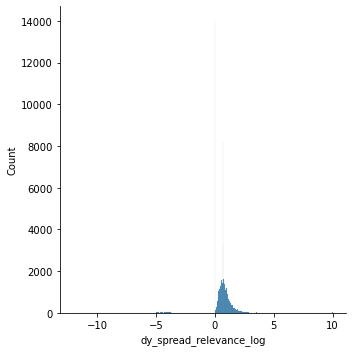

In [33]:
sns.displot(df['dy_spread_relevance_log'])

In [34]:
df[df.columns[df.dtypes=='float64']].max().sort_values(ascending=False)[:50]

pl_mean_std              3.264096e+08
pebit_mean_std           3.264093e+08
evebit_mean_ref_std      2.374685e+08
pebit_mean_ref_std       2.359983e+08
evebit_min_min           1.984852e+08
pl_min_min               1.980619e+08
pebit_min_min            1.980617e+08
psr_mean_ref_mean        1.715095e+08
pebit_mean_ref_mean      9.478616e+07
pacl_spread_relevance    8.755779e+07
evebit_mean_ref_mean     7.452821e+07
pcg_spread_relevance     7.052050e+07
pl_min_ref_min           5.849031e+07
pcg_max_ref_max          4.828849e+07
pcg_ref_spread           4.828848e+07
pcg_mean_ref_std         4.114530e+07
pebit_min_ref_min        3.520027e+07
evebit_min_ref_min       2.900099e+07
pcg_spread               1.678465e+07
mrgliq_ref_spread        1.539477e+07
mrgliq_max_ref_max       1.531735e+07
pcg_mean_ref_mean        1.410573e+07
pcg_max_max              8.643086e+06
pcg_min_ref_min          8.462347e+06
pcg_mean_std             6.051043e+06
pcg_mean_last            5.621509e+06
mrgebit_max_

In [35]:
df.isna().sum().sort_values(ascending=False)[:50]

liq2m_min_min_log                21592
pl_mean_last_log                 16969
pl_mean_mean_log                 16889
evebit_mean_last_log             16600
evebit_mean_mean_log             16463
patrliq_min_min_log              16172
pl_mean_ref_mean_log             14553
pl_spread_relevance_log          14495
pebit_mean_last_log              13879
pebit_mean_mean_log              13823
liq2m_spread_relevance_log       12599
patrliq_mean_mean_log            12198
patrliq_mean_last_log            12117
evebit_max_max_log               10312
patrliq_max_max_log               9744
pebit_spread_relevance_log        9663
evebit_spread_relevance_log       9334
pl_max_max_log                    7918
pebit_max_max_log                 7899
dy_spread_relevance_log           7105
patrliq_mean_ref_mean_log         5580
liq2m_mean_last_log               4436
patrliq_spread_relevance_log      3706
evebit_max_ref_max_log            3672
patrliq_max_ref_max_log           3331
liq2m_mean_ref_mean_log  

In [36]:
df = df.fillna(0)
df.replace([np.inf, -np.inf], 20, inplace=True)

features X_train: 427
features X_test: 427


c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\Pontello\anaconda3\lib\si

R2 score: nan
Mean squared error: nan
test score: 0.47267172142518254 
train score: 0.9999827870997777


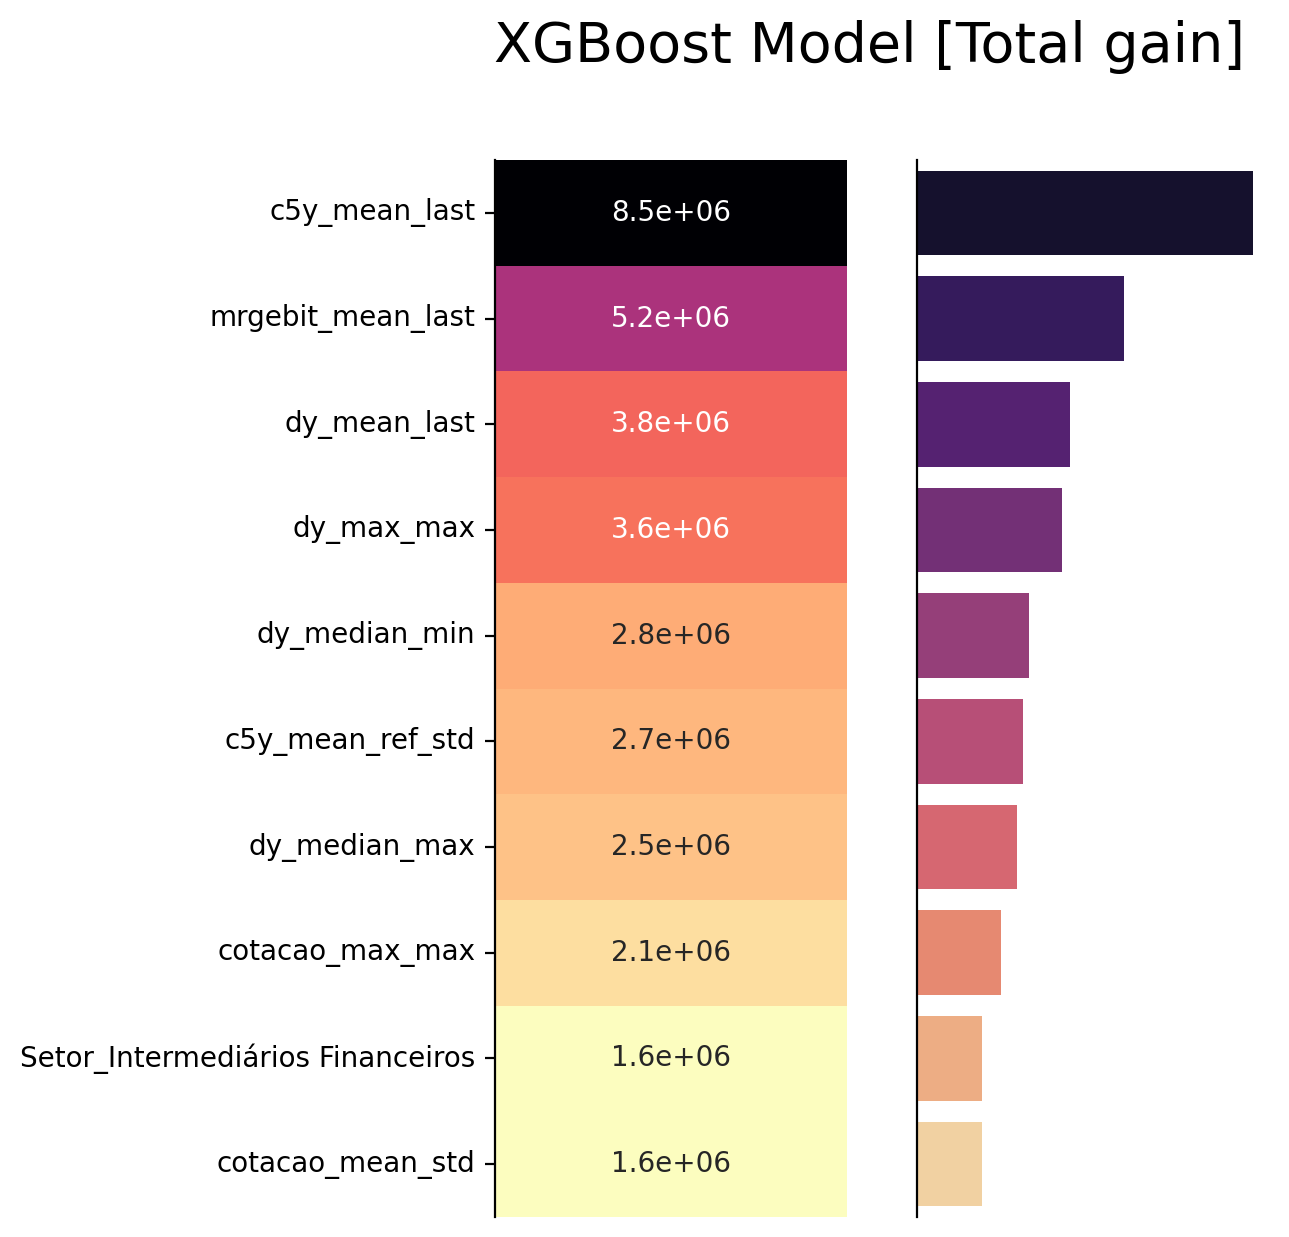

In [37]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df.drop(['Data_ult_cot','Papel','Empresa','dy_label'], axis=1)
# X = df[training_features.index]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

most_important = most_important_XGBoost_review

In [38]:
cols_to_keep = most_important.iloc[:50].index
print(cols_to_keep)

Index(['c5y_mean_last', 'mrgebit_mean_last', 'dy_mean_last', 'dy_max_max',
       'dy_median_min', 'c5y_mean_ref_std', 'dy_median_max', 'cotacao_max_max',
       'Setor_Intermediários Financeiros', 'cotacao_mean_std',
       'evebit_mean_ref_mean', 'dy_median_last', 'Lucro_Liquido_12m_category',
       'dy_mean_std', 'c5y_max_max', 'dy_median_spread', 'dy_mean_mean',
       'pebit_min_min', 'c5y_ref_spread', 'c5y_mean_std', 'roe_mean_ref_mean',
       'liq2m_mean_ref_std_log', 'euro_spread_relevance',
       'liq2m_mean_ref_mean_log', 'c5y_mean_mean', 'dy_min_min',
       'pvp_mean_mean', 'euro_max', 'mrgebit_max_max',
       'patrliq_mean_ref_mean_log', 'c5y_max_ref_max', 'c5y_spread',
       'divbpatr_max_max', 'dolar_comercial_spread_relevance',
       'pl_mean_ref_std_log', 'dolar_comercial_last', 'cotacao_mean_last',
       'roe_mean_mean', 'besst_2_True', 'c5y_spread_relevance', 'roe_min_min',
       'liq2m_spread_relevance_log', 'pcg_mean_mean', 'mrgliq_max_ref_max',
       'cot

In [39]:
# search_term = 'patrliq'
# [col for col in most_important.index if search_term in col]

In [40]:
# cols_to_keep = [
#     'dy_rel',
#     'dy',
#     'dy_std',
#     'pl',
#     'pl_spread_rel_now',
#     'pl_std',
#     'pl_median',
#     'roe_median',
#     'roe_spread_rel_now',
#     'roe',
#     'ipca_std',
#     'patrliq_rel',
#     'patrliq_spread_rel_now',
#     'patrliq_mean_median_ratio',
#     'patrliq_median',
#     'patrliq_field',
#     'roic_rel',
#     'mrgebit_field',
#     'pvp_std',
#     'pvp_rel',
#     'pvp_median',
#     'psr_rel',
#     'preco_do_petroleo_spread_rel_now',
#     'cotacao_mean_median_ratio',
#     'cotacao_spread_rel_now',
#     'cotacao_std',
#     'cotacao_rel',
#     'c5y_rel',
#     'pebit_mean_median_ratio', 
#     'pebit_spread_rel_now',
#     'liq2m_field',
#     'liq2m_mean',
#     'liq2m_spread_rel_now',
#     'liq2m_rel',
#     'mrgliq_field',
#     'mrgliq_spread',
#     'mrgliq_spread_rel_now',
# ]

features X_train: 50
features X_test: 50


CV R2 score: 0.5409616539144562
CV MSE: 206.09748736639114
test score: 0.2561646528403019 
train score: 0.999929746115118


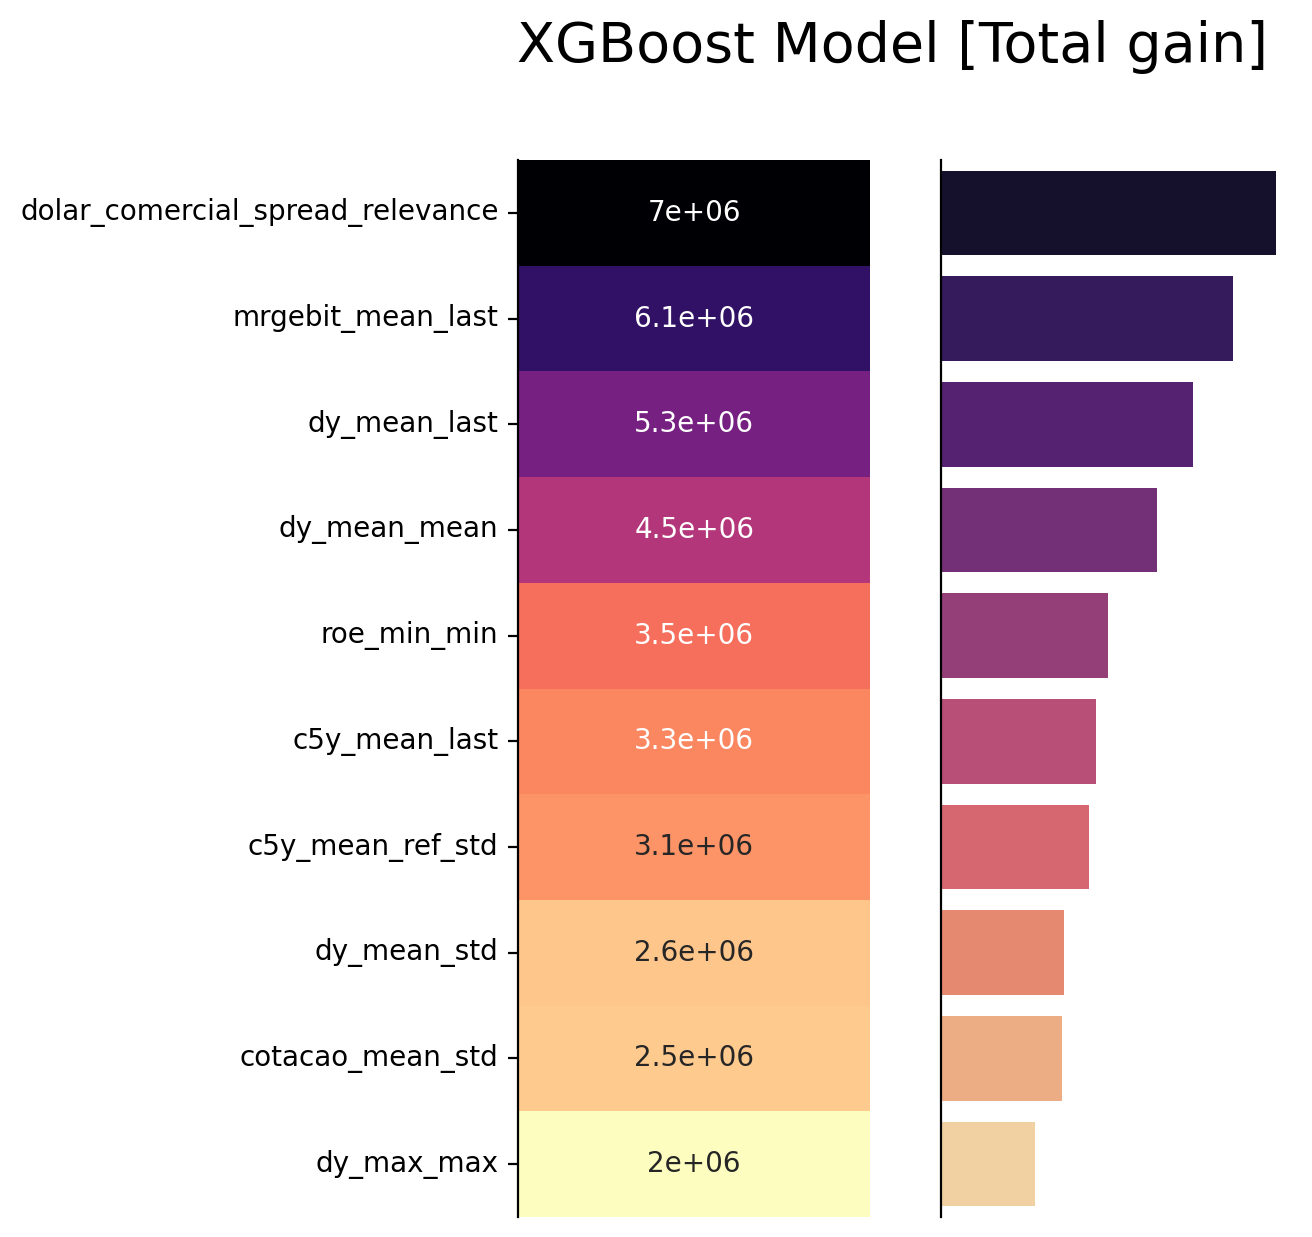

In [41]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df[cols_to_keep]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('CV R2 score:', np.mean(scores['test_r2']))
print('CV MSE:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

### Building a Machine Learning Pipeline 

In [42]:
def build_pipelines(regressors, transformers):
    pipelines = {}
    transformers = [StandardScaler(), Normalizer(), None]
    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [43]:

def build_models(regressors,parameters_dict, transformers):
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}
    
    for transformer in transformers:
        for algorithm,parameters in parameters_dict.items():
            # create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    print(cvs)
    
    return cvs

In [45]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm):

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance
    }

    patch = '../data/03_models/out/'
    filename = patch + algorithm

    # return performance

    json.dump(performance, open(filename+'_results.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+'.pkl', 'wb'))

    return test_score_r2



def main():

    # separating the train and target features
    X = df.drop(['Data_ult_cot','Papel','Empresa','dy_label'], axis=1)
    y = df['dy_label']

    # X = df[training_features.index]
    # y = df['dy_label']

    regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
            'Ridge':Ridge(),
            'Lasso':Lasso(),
            'ElasticNet':ElasticNet()
        }
    transformers = [Normalizer()]
    # transformers = [StandardScaler(), Normalizer()]

    with open('../data/03_models/in/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm)
        print(algorithm, r2)

    return models


models = main()

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.05, 0.1, 0.2],
                         'reg__max_depth': [3, 5, 7],
                         'reg__n_estimators': [50, 100, 200],
                         'reg__subsample': [0.5, 0.8, 1.0]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
               

c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from

{'fit_time': array([114.95494676, 114.079983  , 111.18965387, 111.55025101,
       118.33824897]), 'score_time': array([0.07902122, 0.07500982, 0.08302236, 0.0780189 , 0.07802105]), 'test_r2': array([3.70064109e-05, 3.37210689e-05, 4.68189184e-05, 2.08624084e-05,
       1.66575940e-05]), 'test_mse': array([496.39186725, 324.05271531, 476.17106387, 563.04718719,
       366.03094464]), 'test_xve': array([3.70234232e-05, 8.10444404e-05, 4.69110597e-05, 2.31734648e-05,
       2.16388082e-05]), 'test_MAPE': array([3.57605396e+14, 3.25283299e+14, 3.44177007e+14, 3.58291889e+14,
       3.59144925e+14])}
CV R2 score: 3.1013280115610445e-05
CV MSE: 445.13875565143843
test r2: 0.09192658753010063
test mse: 378.8547961460512
test explained_variance_score: 0.09192734557998583
test MAPE: 890794160543397.2
___________________________________

Best Parameters: {'reg__alpha': 0.01, 'reg__fit_intercept': True, 'reg__normalize': True}
##################################
Ridge_Normalizer() 0.0919265875301

c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavi

{'fit_time': array([156.55722356, 162.06081223, 158.26109505, 156.33708048,
       160.00377107]), 'score_time': array([0.07900882, 0.08302093, 0.07700872, 0.08302259, 0.08201098]), 'test_r2': array([-0.00028803, -0.00071103, -0.00029409, -0.00021843, -0.00032717]), 'test_mse': array([496.55321822, 324.29406261, 476.33340006, 563.18192546,
       366.15680001]), 'test_xve': array([0., 0., 0., 0., 0.]), 'test_MAPE': array([0.79025438, 0.79656496, 0.79811321, 0.7933637 , 0.7933637 ])}
CV R2 score: -0.0003677510275919005
CV MSE: 445.30388127316974
test r2: 0.07060231246648985
test mse: 387.7514379497274
test explained_variance_score: 0.07060232393332277
test MAPE: 171178331723091.53
___________________________________

Best Parameters: {'reg__alpha': 0.001, 'reg__fit_intercept': True, 'reg__normalize': True}
##################################
Lasso_Normalizer() 0.07060231246648985
ElasticNet_Normalizer()


c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be remo

{'fit_time': array([252.13885522, 260.01483727, 256.90457034, 250.710706  ,
       250.7787776 ]), 'score_time': array([0.08102107, 0.08702207, 0.07701969, 0.08000994, 0.0790081 ]), 'test_r2': array([3.81657037e-03, 6.17131668e-03, 2.60845885e-03, 4.94689170e-06,
       1.73530511e-06]), 'test_mse': array([494.51565301, 322.06374371, 474.95122795, 563.05614857,
       366.03640675]), 'test_xve': array([3.81681987e-03, 6.21367136e-03, 2.60888311e-03, 8.37099176e-06,
       8.48099903e-06]), 'test_MAPE': array([3.62808067e+14, 3.30259136e+14, 3.49356788e+14, 3.67205429e+14,
       3.68280492e+14])}
CV R2 score: 0.002520605619922911
CV MSE: 444.1246359962776
test r2: 0.03955214998690182
test mse: 400.705790334641
test explained_variance_score: 0.03955249250224202
test MAPE: 268157554549265.94
___________________________________

Best Parameters: {'reg__alpha': 0.001, 'reg__l1_ratio': 0.8, 'reg__normalize': True}
##################################
ElasticNet_Normalizer() 0.0395521499869018

In [46]:
models

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                        ('reg', LGBMRegressor())]),
              param_grid={'reg__learning_rate': [0.05, 0.1, 0.2],
                          'reg__max_depth': [3, 5, 7],
                          'reg__n_estimators': [50, 100, 200],
                          'reg__subsample': [0.5, 0.8, 1.0]},
              scoring='r2'),
 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                        ('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
